# Capillary Action Model

In [2]:
import sys
sys.path.append("..")
from sicm.models.model import Pipette, Medium, CapillaryAction

import numpy as np

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
# for theta: https://iopscience.iop.org/article/10.1088/2051-672X/aa6e02/meta
medium = Medium(theta = 20, gamma = 0.072, rho = 997 - 1.184)
pipette = Pipette(length = 4e-2, d_body = 200e-6, d_tip = 3e-6, alpha = 5)

..\sicm\models\model.py:404: RuntimeWarning: invalid value encountered in arccos
  alpha = self.medium.theta - np.rad2deg(np.arccos(cos_alpha_hat))
C:\Users\mholub\AppData\Local\Continuum\miniconda3\envs\sicm\lib\site-packages\matplotlib\__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
C:\Users\mholub\AppData\Local\Continuum\miniconda3\envs\sicm\lib\site-packages\matplotlib\__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
C:\Users\mholub\AppData\Local\Continuum\miniconda3\envs\sicm\lib\site-packages\matplotlib\__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2

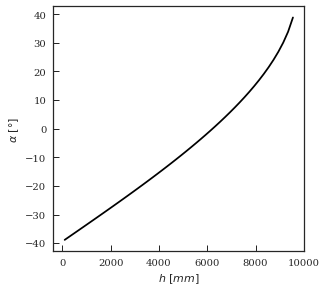

In [4]:
ca = CapillaryAction(medium, pipette)
h_span = np.linspace(1e-1, 2e1, 100)
alpha_span = ca._calculate_alpha(h_span)
ca.plot(h_span*1e3, alpha_span, r"$h\ [mm]$", r"$\alpha\ [\degree]$")

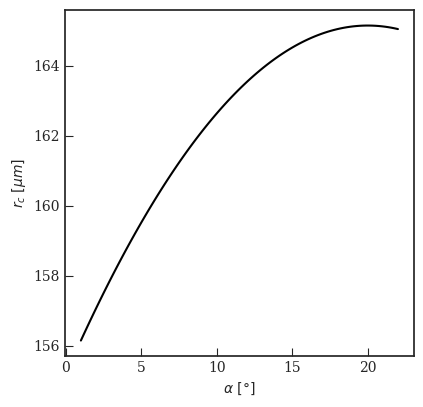

In [7]:
ca = CapillaryAction(medium, pipette)
alpha_span = np.linspace(1, 22, 100)
rc_span = ca._calculate_constriction(alpha_span)
ca.plot(alpha_span, rc_span*1e6, r"$\alpha\ [\degree]$", r"$r_c\ [\mu m]$",)

# Nanoparticle Heaters Model
Model of single nanoparticle as a heater. For references, see OneNote notebook and Zotero (tag:nannoparticles.)

In [1]:
import sys
sys.path.append("..")
from sicm.plots import plot_generic

import numpy as np

%load_ext autoreload
%autoreload 2

In [3]:
def calculate_temperature_increase(I, sigma, kappa, r):
    """Calculate temperature increase around single plasmonic NP
    
    Parameters
    ----------------
    I: float
        incident power density in W/cm2
    sigma: float
        Absorption cross section in cm2
    kappa: float
        Heat conductivity in W/(m.K)
    r: float or array-like
        Distances at which to calculate temperature increase, in nm
    
    Returns
    -----------------
    T_delta: float or array-like
        Temperature increase at distances r, in K
    """
    r = r * 1e-7 # convert nanometers to centimeters
    T_increase = (I * sigma) / (4 * np.pi * kappa) * (1/ r)
    return T_increase

def calculate_power_density(P, d):
    """Calculate power density supplied by laser
    
    Parameters
    ----------
    P: float
        Power in W
    d: float
        Laser spot diameter at focal plane, in mm
    
    Returns
    ----------
    rho: float
        Power density in W/cm2
    """
    d = d / 10 # convert mm to cm
    A = np.pi * (d / 2)**2
    rho = P / A
    return rho

def plot_temperature(r, T, x_lab = r"$r\ [nm]$", y_lab = r"$\Delta T\ [K]$",):
    """Render plot of r vs T"""
    plot_generic([r], [T], [x_lab], [y_lab])

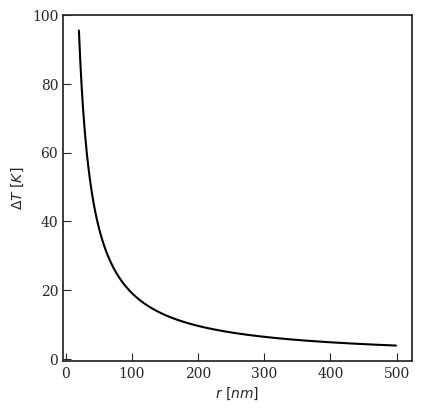

In [5]:
P = 0.5 # power in watts
transmitance = 0.85 # transmitace at given wavelength
d = 0.575 # laser spot diameter in mm
sigma = 8.8e-6 # absorption cross section in cm2
kappa = 0.6 # thermal conductivity of medium
r = np.arange(20, 500, 1) # distance in nm

I = calculate_power_density(P * transmitance, d)
T_delta = calculate_temperature_increase(I, sigma, kappa, r)
plot_temperature(r, T_delta)


# Gaussian Beam Model

Fit gaussian beam to an image data

In [21]:
import sys
sys.path.append("..")
from sicm import io, plots
import numpy as np
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
datadir = "S:\\UsersData\\Martin\\2019\\05_May\\14"
exp_name = "laser_beam_40x_4p96AU.png"
img = io.rgb2gray(io.load_image(datadir, exp_name))
plt.imshow(img)

Ok this is fine. next you should bedoing something like

```python
thresh = skimage.thresh(moving_average(img))
img_binary = img > threhs
center, radius = fit_circle(img_binary)
img_rcoords = convert_to_polar(img, center, y)

gbeam = GaussianBeam(img_coords, img)

gbeam.fit()
print(gbeam.fwhm)
```